# 1. Acquire

In [1]:
# Import Python Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Acquire and Prep Files
import Acquire
import os 
import Prepare 

# Import for model object and metric functions
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from scipy import stats
from math import sqrt

# Import Warnings 
import warnings
warnings.filterwarnings("ignore")

print('Imports Completed.')

Imports Completed.


In [2]:
df = Acquire.get_mvp_home_data() 

In [3]:
df.head()

,id,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt
0,1018,1819.0,3.0,2.0,478430.0
1,1248,1000.0,0.0,0.0,27400.0
2,1734,1503.0,2.0,2.0,171687.0
3,1772,1604.0,4.0,2.0,498347.0
4,2028,2384.0,3.0,3.0,549917.0


# 2. Prepare

In [4]:
df.shape

(19149, 5)

In [5]:
df.describe() 

,id,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt
count,19149.000000,18783.000000,19149.000000,19149.000000,1.884100e+04
mean,52465.910805,1784.874621,3.006632,2.205833,4.443516e+05
std,6396.665259,965.575765,1.148385,1.035924,5.547795e+05
min,1018.000000,60.000000,0.000000,0.000000,1.000000e+01
25%,47163.000000,1204.000000,2.000000,2.000000,1.925360e+05
50%,52742.000000,1557.000000,3.000000,2.000000,3.294930e+05
75%,57785.000000,2102.500000,4.000000,3.000000,5.280000e+05
max,62970.000000,26345.000000,10.000000,19.500000,1.717000e+07


In [6]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19149 entries, 0 to 19148
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            19149 non-null  int64  
 1   calculatedfinishedsquarefeet  18783 non-null  float64
 2   bedroomcnt                    19149 non-null  float64
 3   bathroomcnt                   19149 non-null  float64
 4   taxvaluedollarcnt             18841 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 897.6 KB


In [7]:
df.isnull().sum() 

id                                0
calculatedfinishedsquarefeet    366
bedroomcnt                        0
bathroomcnt                       0
taxvaluedollarcnt               308
dtype: int64

In [8]:
# Dropping null values
df = df.dropna()

In [9]:
df.isnull().sum() 

id                              0
calculatedfinishedsquarefeet    0
bedroomcnt                      0
bathroomcnt                     0
taxvaluedollarcnt               0
dtype: int64

In [10]:
# Renaming columns
df = df.rename(columns = {'calculatedfinishedsquarefeet':'sqft'})
df = df.rename(columns = {'bedroomcnt':'bedroom_count'})
df = df.rename(columns = {'bathroomcnt':'bathroom_count'})
df = df.rename(columns = {'taxvaluedollarcnt':'tax_value'})

In [11]:
# Drop id column
df = df.drop(columns='id')
df.head()

,sqft,bedroom_count,bathroom_count,tax_value
0,1819.0,3.0,2.0,478430.0
1,1000.0,0.0,0.0,27400.0
2,1503.0,2.0,2.0,171687.0
3,1604.0,4.0,2.0,498347.0
4,2384.0,3.0,3.0,549917.0


<b>Takeaways: </b>
- There are some definite outliers in the dataset on the low end of square feet and tax value
- Still not sure whether 0 bedroom/ 0 bathroom is refering to a studio apartment or some other situation

# 3. Explore

### Continuous and Continuous Variables  

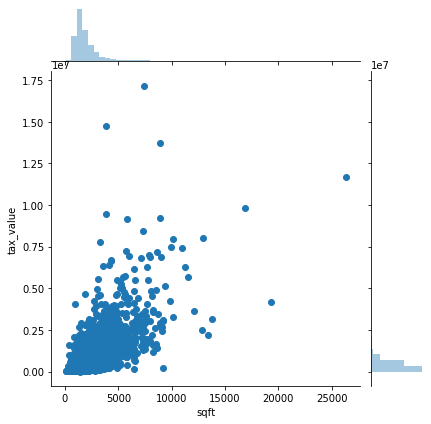

In [12]:
sns.jointplot(x= 'sqft', y='tax_value', data=df)

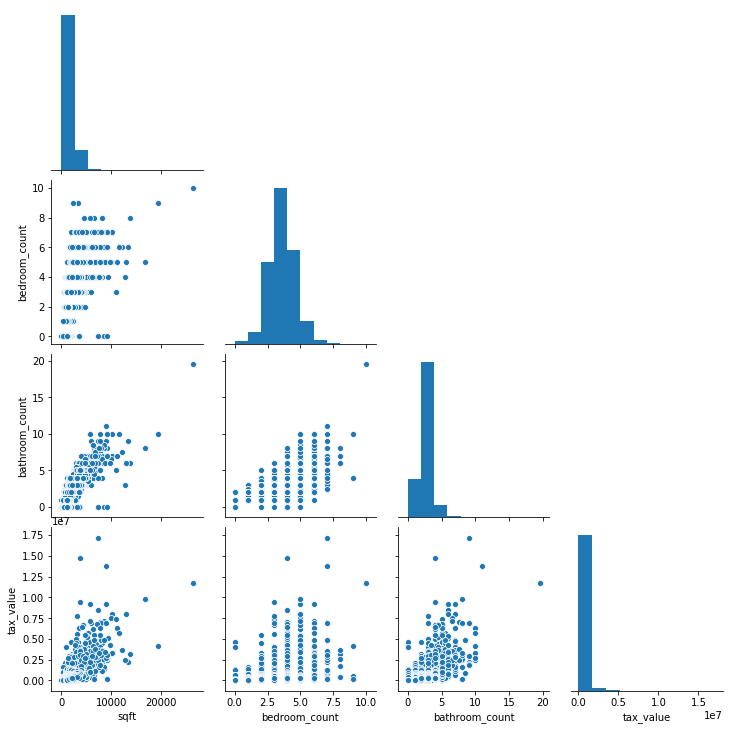

In [13]:
sns.pairplot(df, corner=True) 

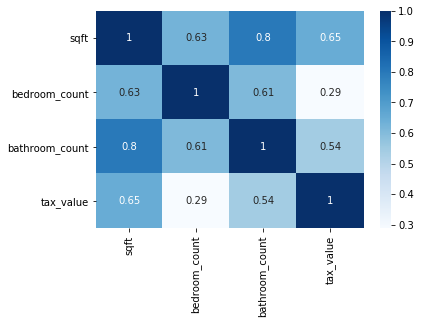

In [14]:
sns.heatmap(df.corr(), cmap='Blues', annot=True)

### Continuous and Categorical Variables

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

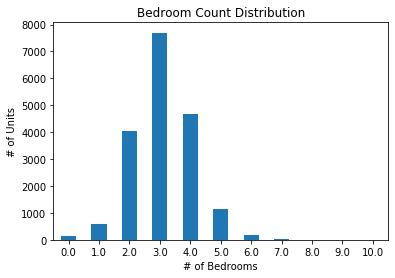

In [15]:
df.bedroom_count.value_counts().sort_index().plot.bar(title='Bedroom Count Distribution')
plt.xlabel('# of Bedrooms')
plt.ylabel('# of Units')
plt.xticks(rotation=0) 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 <a list of 21 Text xticklabel objects>)

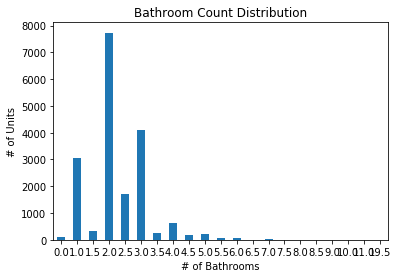

In [16]:
df.bathroom_count.value_counts().sort_index().plot.bar(title='Bathroom Count Distribution')
plt.xlabel('# of Bathrooms')
plt.ylabel('# of Units') 
plt.xticks(rotation=0) 

### Categorical and Categorical Variables

(0, 25)

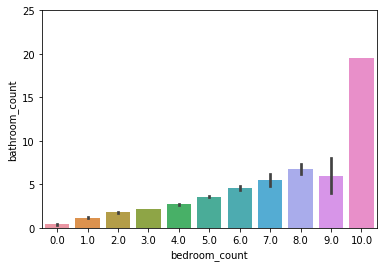

In [17]:
sns.barplot(data=df, x='bedroom_count', y='bathroom_count')
plt.ylim(0,25) 

In [18]:
pd.crosstab(df.bedroom_count, df.bathroom_count, normalize='index') 

bathroom_count,0.0,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,...,6.0,6.5,7.0,7.5,8.0,8.5,9.0,10.0,11.0,19.5
bedroom_count,,,,,,,,,,,,,,,,,,,,,
0.0,0.650407,0.308943,0.000000,0.040650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1.0,0.000000,0.831405,0.021488,0.133884,0.006612,0.006612,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2.0,0.000248,0.356912,0.032018,0.435592,0.063788,0.107471,0.001737,0.001986,0.000000,0.000248,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3.0,0.000130,0.131220,0.018319,0.527738,0.114980,0.181499,0.009874,0.012732,0.001559,0.001819,...,0.000130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4.0,0.000644,0.009225,0.006651,0.368161,0.114997,0.371594,0.029822,0.059000,0.015876,0.016949,...,0.002575,0.000000,0.001073,0.000215,0.000215,0.000000,0.000000,0.000000,0.000000,0.0
5.0,0.000876,0.006135,0.003506,0.094654,0.038563,0.417178,0.041192,0.164768,0.058720,0.088519,...,0.031551,0.002629,0.010517,0.001753,0.001753,0.000876,0.002629,0.000876,0.000000,0.0
6.0,0.000000,0.005319,0.000000,0.047872,0.010638,0.218085,0.005319,0.260638,0.037234,0.148936,...,0.085106,0.015957,0.085106,0.005319,0.015957,0.005319,0.010638,0.010638,0.000000,0.0
7.0,0.000000,0.000000,0.000000,0.000000,0.027027,0.081081,0.027027,0.297297,0.027027,0.216216,...,0.027027,0.027027,0.081081,0.000000,0.054054,0.000000,0.054054,0.054054,0.027027,0.0
8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.400000,0.000000,0.400000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.0


<b>Takeaways: </b>
- Most homes have 3 bedrooms/ 2 baths

### Train, Validate, and Test

In [19]:
# split into train, validate, and test sets
train_and_validate, test = train_test_split(df, random_state=123)
train, validate = train_test_split(train_and_validate, random_state=123)

In [20]:
# Split into X and y
X_train = train.drop(columns='tax_value')
y_train = train[['tax_value']]

# Validate split
X_validate = validate.drop(columns='tax_value')
y_validate = validate[['tax_value']]

# Test split
X_test = test.drop(columns='tax_value')
y_test = test[['tax_value']]

### Scale Data

In [21]:
# 1. Create the Scaling Object
scaler = sklearn.preprocessing.StandardScaler()

# 2. Fit to the train data only
scaler.fit(train.drop('tax_value', axis=1))

# 3. use the object on the whole df
# this returns an array, so we convert to df in the same line
train_scaled = pd.DataFrame(scaler.transform(train.drop('tax_value', axis=1)))
validate_scaled = pd.DataFrame(scaler.transform(validate.drop('tax_value', axis=1)))
test_scaled = pd.DataFrame(scaler.transform(test.drop('tax_value', axis=1)))

In [22]:
# Train
train_scaled.index = train.index
train_scaled.columns = ['bath_count_scaled','bed_count_scaled','square_feet_scaled']
train = pd.concat((train, train_scaled), axis=1)

# Validate
validate_scaled.index = validate.index
validate_scaled.columns = ['bath_count_scaled','bed_count_scaled','square_feet_scaled']
validate = pd.concat((validate, validate_scaled), axis=1)

# Test
test_scaled.index = test.index
test_scaled.columns = ['bath_count_scaled','bed_count_scaled','square_feet_scaled']
test = pd.concat((test, test_scaled), axis=1)

### Run Tests

- T-test 
- Correlation test

In [23]:
train.head()

,sqft,bedroom_count,bathroom_count,tax_value,bath_count_scaled,bed_count_scaled,square_feet_scaled
12399,1032.0,3.0,1.5,57905.0,-0.818349,-0.114318,-0.823176
109,2120.0,4.0,2.0,447300.0,0.362362,0.879752,-0.295499
4039,442.0,0.0,0.0,49613.0,-1.458625,-3.096527,-2.406207
6805,1734.0,3.0,2.0,492395.0,-0.056530,-0.114318,-0.295499
16784,1029.0,2.0,2.0,314030.0,-0.821605,-1.108388,-0.295499


### T-test

$H0$: The average price of homes with 5000 sq.ft. or more is equal to the average price of homes with 5000 sq.ft. or less.  
$H1$: Homes with 5000 sq.ft. or more have higher than average tax dollar count.

In [24]:
train.sqft.mean()

1786.0913461538462

In [25]:
df_less_than_5000 = train[train.sqft >= 5000]
df_greater_than_5000 = train[train.sqft > 5000]

In [26]:
a = df_less_than_5000.tax_value.mean()

b = df_greater_than_5000.tax_value.mean()

t, p = stats.ttest_ind(df_greater_than_5000.tax_value,
                df_less_than_5000.tax_value)

if p > a:
    print('We Fail to Reject H0')
else:
    print('We Reject H0')

We Reject H0


$H0$: Average price of homes with more than two bathrooms is equal to the average price of homes with less than two bathrooms.    
$H1$: Homes with more than two bathrooms have higher than average tax dollar count.

In [27]:
train.bathroom_count.mean()

2.28

In [28]:
df_less_than_2_bath = train[train.bathroom_count >= 2]
df_greater_than_2_bath = train[train.bathroom_count > 2]

In [29]:
a = df_less_than_2_bath.tax_value.mean()

b = df_greater_than_2_bath.tax_value.mean()

t, p = stats.ttest_ind(df_greater_than_2_bath.tax_value,
                df_less_than_2_bath.tax_value)

if p > a:
    print('We Fail to Reject H0')
else:
    print('We Reject H0')

We Reject H0


### Correlation Test

$H0$: There is no relationship between total house square feet and tax value   
$H1$: There is a relationship between total house square feet and tax value

In [30]:
confidence_interval = 0.95
alpha = 1 - confidence_interval 
t, p = stats.pearsonr(X_train.sqft, y_train.tax_value)

corr, p = stats.pearsonr(train['sqft'], train['tax_value'])
print(corr, p)

if p > alpha:
    print('We Fail to Reject H0')
else:
    print('We Reject H0a')

0.6315673550964442 0.0
We Reject H0a


# 4. Model

- Develop a regression model that performs better than a baseline 
- Extablish a baseline model
- Document various algorithms and/or hyperparameters
- Plot the residuals
- Compute the evaluation metrics (SSE, RMSE, and/or MSE)
- Compare to baseline
- Plot y by ^y
- Create a model.py file

### Baseline Model

# 5. Conclusions